# Testing the grid-based K-function on simulated point patterns

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import ripleyk as rk
 
from time import time

from k_function import *
from process_images import *
from plotting import *
from toy_data_generation import *
from utils import *

### Some examples for simulated point patterns

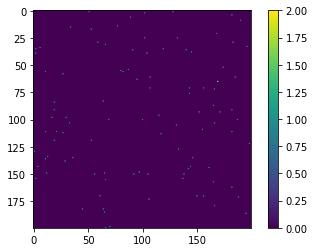

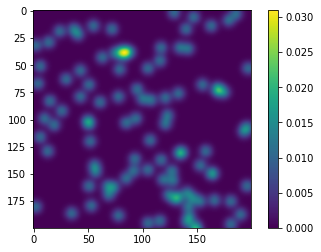

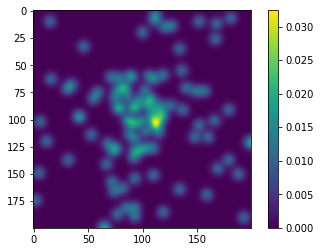

In [2]:
# the function generates two-dimensional point coordinates
# as well as an image of the points casted onto a discrete grid
points, grid = generate_points_and_grid(
    d=200, 
    n=100, 
    dilate_points=False,
    pixel_sigma=0
)
plt.imshow(grid)
plt.colorbar()
plt.show()

points, grid = generate_points_and_grid(
    d=200, 
    n=100, 
    dilate_points=True, 
    pixel_sigma=4
)
plt.imshow(grid)
plt.colorbar()
plt.show()

points, grid = generate_points_and_grid(
    d=200, 
    n=100, 
    n_cluster=50,
    dilate_points=True,
    pixel_sigma=4
)
plt.imshow(grid)
plt.colorbar()
plt.show()

### Useful functions for conducting experiments with the grid-based K-function

In [3]:
# define two functions to compute normalized values of the original
# and grid-based K-functions to accurately compare their values

def grid_K_func_norm(arr, range_of_t):
    norm = ripleys_K_grid(arr, [np.inf])[0]
    return np.array(ripleys_K_grid(arr, range_of_t)) / norm

def orig_K_func_norm(points_x, points_y, range_of_t):
    """
    Implementation used for original K-function: https://pypi.org/project/ripleyk/
    """
    norm = rk.calculate_ripley([np.inf], 1, points_x, points_y)
    return np.array(rk.calculate_ripley(range_of_t, 1, points_x, points_y)) / norm


def simulate_K_functions(d, n, n_cluster, n_iter, dilate_points, pixel_sigma):
    """
    Simulates images of point patterns and computes true K-function, 
    grid-based K-function, and K-function computed on points extracted as 
    local maxima in pixel intensity. Computes relative errors 
    w.r.t. the true K-function.
    
    Args:
        d (int): Dimension for grid, d x d.
        n (int): Total number of points. Sum of random points 
            and clustered points.
        n_cluster (int): Number of points clustered according to a 
            2D Gaussian distribution.
        n_iter (int): Number of simulations.
        dilate_points (bool): If True, points span several pixels by using 
            a Gaussian blur.
        pixel_sigma (float): Std for Gaussian blur when dilating the points.
    
    Returns:
        dict: Dictionary containing settings and results of the simulations.
    """
    experiment_dict = dict()
    errors_grid = []
    errors_extr = []
    csr = np.ones((d, d)) / d**2 * n

    tic = time()

    for i in range(n_iter):
        points, grid = generate_points_and_grid(d=d, n=n, n_cluster=n_cluster,
                                                dilate_points=dilate_points, 
                                                pixel_sigma=pixel_sigma)
        points_x = points[:, 0]
        points_y = points[:, 1]
        det = detect_peaks(grid).astype(int)
        extr_x, extr_y = np.where(det==1)

        range_of_t = list(np.linspace(5, d, 40))

        K_vals_csr = grid_K_func_norm(csr, range_of_t)
        K_vals_orig = orig_K_func_norm(points_x, points_y, range_of_t) - K_vals_csr
        K_vals_extr = orig_K_func_norm(extr_x, extr_y, range_of_t) - K_vals_csr
        K_vals_ours = grid_K_func_norm(grid, range_of_t) - K_vals_csr

        abs_rel_error_our = abs((K_vals_orig-K_vals_ours) / K_vals_orig)
        abs_rel_error_extr = abs((K_vals_orig-K_vals_extr) / K_vals_orig)

        errors_grid.append(abs_rel_error_our)
        errors_extr.append(abs_rel_error_extr)

    err_grid_mean = np.mean(errors_grid, axis=0)
    err_grid_std = np.std(errors_grid, axis=0)
    err_extr_mean = np.mean(errors_extr, axis=0)
    err_extr_std = np.std(errors_extr, axis=0)

    toc = time()
    print(f"Simulation(s) took {toc-tic:.4f} seconds")
    
    experiment_dict['d'] = d
    experiment_dict['n'] = n
    experiment_dict['n_iter'] = n_iter
    experiment_dict['grid'] = grid
    experiment_dict['extr_y'] = extr_y
    experiment_dict['extr_x'] = extr_x
    experiment_dict['range_of_t'] = range_of_t
    # out of all simulations, use last computed K-function
    # as example for plotting
    experiment_dict['K_vals_csr'] = K_vals_csr
    experiment_dict['K_vals_orig'] = K_vals_orig
    experiment_dict['K_vals_extr'] = K_vals_extr
    experiment_dict['K_vals_ours'] = K_vals_ours
    experiment_dict['err_grid_mean'] = err_grid_mean
    experiment_dict['err_grid_std'] = err_grid_std
    experiment_dict['err_extr_mean'] = err_extr_mean
    experiment_dict['err_extr_std'] = err_extr_std
    
    return experiment_dict


### Example results for the grid-based K-function
The results of the simulations highlight that the grid-based K-function can accurately approximate the "true" K-function in scenarios with blurred and densely overlapping points. In these situations, accurately extracting the true points, and then computing the standard ("original") K-function is shown to be less reliably in these situations. 

\
Note: Shown are the $K_{diff}$ functions which are computed by comparing the observed K-function and the K-function for the case of complete spatial randomness (CSR):

$K_{diff} = K_{CSR} - K_{obs}$

Simulation(s) took 1.6619 seconds


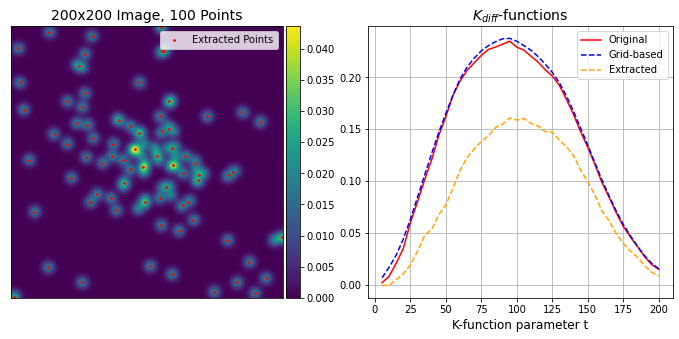

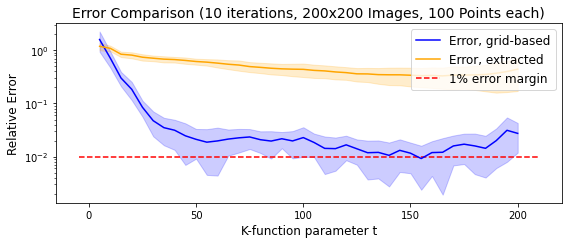

In [4]:
# WARNING:
# Large images (large dimension d) can take several minutes to compute
# when using several repetitions, i.e. n_iter > 1; and large numbers of points
# can take long for the standard (original) K-function to compute!
n_iter = 10
d = 200
n = 100
n_cluster = 50
dilate_points = True
pixel_sigma = 3

experiment_dict = simulate_K_functions(d, n, n_cluster, n_iter, dilate_points, pixel_sigma)
# one example of simulated point pattern and K_diff-functions
plot_K_diff_comparison(experiment_dict)
# mean and std of relative errors for n_iter simulated point patterns
plot_relative_error_comparison(experiment_dict)

Simulation(s) took 3.0691 seconds


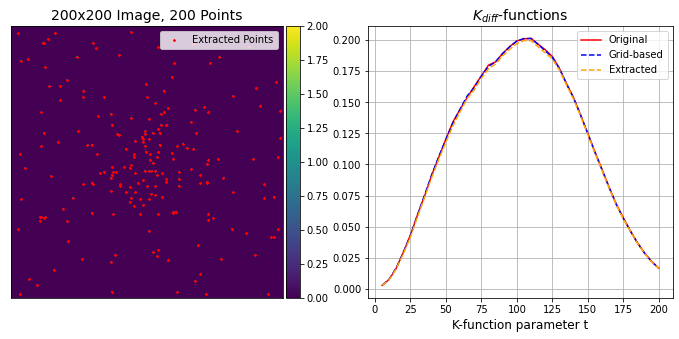

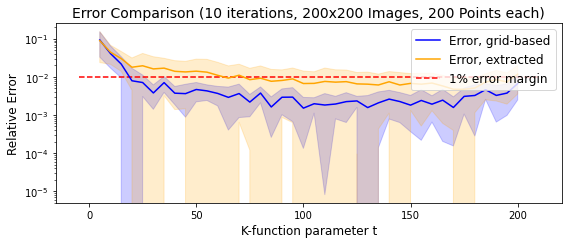

In [9]:
# WARNING:
# Large images (large dimension d) can take several minutes to compute
# when using several repetitions, i.e. n_iter > 1; and large numbers of points
# can take long for the standard (original) K-function to compute!
n_iter = 10
d = 200
n = 200
n_cluster = 70
dilate_points = False
pixel_sigma = 3

experiment_dict = simulate_K_functions(d, n, n_cluster, n_iter, dilate_points, pixel_sigma)
# one example of simulated point pattern and K_diff-functions
plot_K_diff_comparison(experiment_dict)
# mean and std of relative errors for n_iter simulated point patterns
plot_relative_error_comparison(experiment_dict)

*Note: when not using blur, pixel intensities > 1 indicate overlap, i.e. when points are exactly on top of each other*